# Prerequisites

In [ ]:
%pip install torch torchvision torchviz torchinfo > None

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
import matplotlib.pyplot as plt
from torchinfo import summary
import random
import math
import numpy as np

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
def comp_graph(model, shape=[28, 28], channels=1):
  # Put on the same device
  model = model.to('cpu')
  model.eval()
  # Pass a dummy input through the network
  sample_input = torch.randn(1, channels, shape[0], shape[1]).to('cpu')  # batch_size=1, channels=1, height=X, width=Y
  y = model(sample_input)

  # Creating Graph
  dot = make_dot(y, params=dict(model.named_parameters()))
  model.train()
  return dot

def summary_model(model, shape=[28, 28], channels=1):
  return summary(model, input_size=(64, channels, shape[0], shape[1]))

def loss_plt(train_losses, val_losses):
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Val Loss")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("MSE Loss")
  plt.title("Training curve")
  plt.show()

def plot_res(model):
  grid_size = 50
  x1_lin = np.linspace(-2, 2, grid_size)
  x2_lin = np.linspace(-2, 2, grid_size)
  X1, X2 = np.meshgrid(x1_lin, x2_lin)  # shape (grid_size, grid_size)

  # Target
  Y_true = true_function(X1, X2)

  # Prediction
  X1_flat = X1.ravel()
  X2_flat = X2.ravel()
  cache_grid = model.forward(X1_flat, X2_flat)
  Y_pred = cache_grid["y_hat"].reshape(X1.shape)

  plt.figure(figsize=(12,5))

  plt.subplot(1,2,1)
  plt.title("True function: sin(x1)+cos(x2)")
  plt.imshow(Y_true, origin='lower',
            extent=(-2,2,-2,2), aspect='auto')
  plt.colorbar()

  plt.subplot(1,2,2)
  plt.title("Model prediction")
  plt.imshow(Y_pred, origin='lower',
            extent=(-2,2,-2,2), aspect='auto')
  plt.colorbar()

  plt.show()

In [ ]:
def get_mnist_data():
  # Transform: convert images to tensors & normalize
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))  # for grayscale mean=0.5, std=0.5
  ])

  # Download and create Datasets
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
  test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

  # Visualisation
  examples = iter(test_loader)
  example_data, example_targets = next(examples)

  fig = plt.figure()
  for i in range(6):
      plt.subplot(2, 3, i+1)
      plt.tight_layout()
      plt.imshow(example_data[i][0], cmap='gray')
      plt.title(f"Label: {example_targets[i].item()}")
      plt.axis('off')
  plt.show()

  return train_loader, test_loader

def get_cifar_data():
  # Data augmentation and normalization for CIFAR
  transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),  # a bit of augmentation
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))
  ])

  transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))
  ])

  train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
  test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

  # batch from DataLoader: (B, C, H, W)
  data_iter = iter(test_loader)
  images, labels = next(data_iter)

  fig = plt.figure(figsize=(8,4))
  for i in range(6):
      plt.subplot(2, 3, i+1)
      plt.tight_layout()

      # (C,H,W) -> (H,W,C)
      img = images[i].permute(1,2,0).clone()  # clone() for not in-place ops

      # Back norm for drawing
      mean = torch.tensor([0.5, 0.5, 0.5])
      std  = torch.tensor([0.5, 0.5, 0.5])
      img = img * std + mean  # For each C

      # Now img is in [0..1]
      img = torch.clamp(img, 0, 1)  # Clipping for float-ops errors

      plt.imshow(img)
      plt.title(f"Label: {labels[i].item()}")
      plt.axis('off')

  plt.show()

  return train_loader, test_loader


# Mnist
**Dataset**:
* Image shapes: 28x28
* Image channels: 1
* Num classes: 10

**Model**:
* FC (3 layers):
  * Input_size*Input_size x 256
  * 256 x 128
  * 128 x num_classes
* Relu activation

**Training**:
* Epochs: 5
* Optimizer: Adam
* LR: 0.001
* CrossEntropyLoss
* Needed accuracy: ~97%

**Helpful links**:
1.   https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html
2.   https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
3.   https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
4.   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
5.   https://pytorch.org/docs/stable/generated/torch.optim.Adam.html



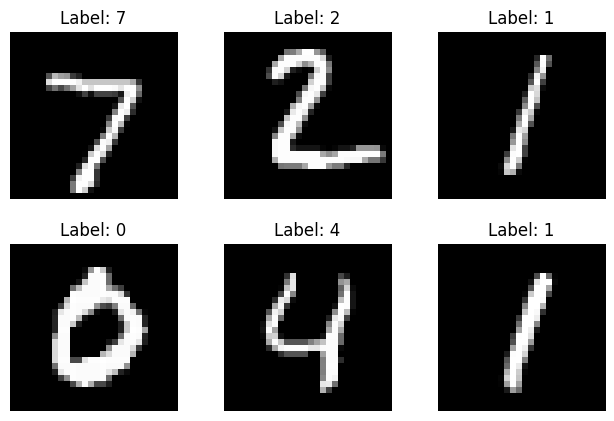

In [ ]:
train_loader, test_loader = get_mnist_data()

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # Dont forget to flatten
        <YOUR CODE HERE>

    def forward(self, x):
        <YOUR CODE HERE>

model = SimpleMLP()
print(model)

SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
print(summary_model(model))
comp_graph(model)

In [ ]:
# Training loop
learning_rate = <YOUR CODE HERE>
epochs = <YOUR CODE HERE>

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        <YOUR CODE HERE>

        running_loss += loss.item()
        if (batch_idx+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0


In [ ]:
# Test loop
correct = 0
total = 0
model.eval()  # switch to evaluation mode
with torch.no_grad():
    for data, targets in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


# CIFAR-10
**Dataset**:
* Image shapes: 32x32
* Image channels: 3
* Num classes: 10

**Model**:
* ResNet
* Device: Only gpu, please

**Training**:
* Epochs: 10
* Optimizer: SGD
  * lr: 0.1
  * momentum: 0.9,
  * weight_decay: 5e-4
* LR: StepLR Scheduler
  * step_size: 5
  * gamma: 0.1
* CrossEntropyLoss
* Needed accuracy: ~80%

**Helpful links**:
1.   https://pytorch.org/vision/stable/models/resnet.html
2.   https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
3.   https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
4.   https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html





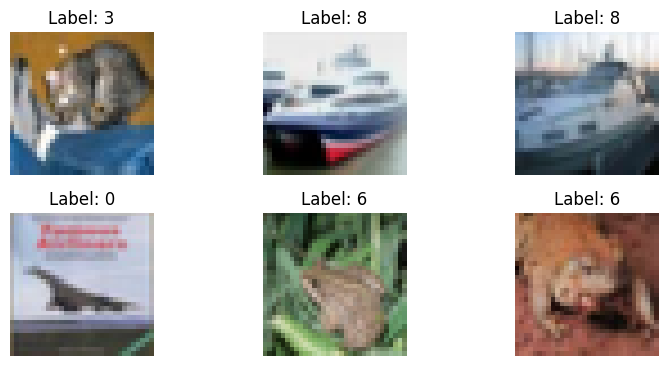

In [ ]:
train_loader, test_loader = get_cifar_data()

In [ ]:
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

resnet = <YOUR CODE HERE>
# By default, ResNet18 expects 1000 classes for ImageNet, so let's adjust the final layer:
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

# Viz our resnet
print(summary_model(resnet, shape=[32,32], channels=3))
comp_graph(resnet, shape=[32,32], channels=3)

In [ ]:
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = <YOUR CODE HERE>
scheduler = <YOUR CODE HERE>

# Use gpu, please
resnet = resnet.to(device)

epochs = 15
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        <YOUR CODE HERE>

        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0
    scheduler.step()


In [ ]:
resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


# Manual Backprop

We want to approximate the function
$$f(x_1, x_2) = \sin(x_1) + \cos(x_2)$$
by training a small neural network from scratch

# 1. Model Architecture

1. Input: two scalars \((x_1, x_2)\), which we stack into a vector $\mathbf{x} \in \mathbb{R}^2$.  
2. Hidden Layer: 8 neurons, each with a $\tanh$ activation.  
3. Output Layer: a single scalar $\hat{y}$.

We define:
$$
\begin{aligned}
\mathbf{z}_1 &= \mathbf{x} \,\mathbf{W}_1 + \mathbf{b}_1,
\quad& &\text{where } \mathbf{W}_1 \in \mathbb{R}^{2 \times 8}, \;\mathbf{b}_1 \in \mathbb{R}^{8}, \\[4pt]
\mathbf{h}_1 &= \tanh(\mathbf{z}_1),
\quad& &\text{(\(8\)-dim hidden)}\\[4pt]
z_2 &= \mathbf{h}_1 \cdot \mathbf{w}_2 + b_2,
\quad& &\text{where } \mathbf{w}_2 \in \mathbb{R}^{8}, \;b_2 \in \mathbb{R}, \\[4pt]
\hat{y} &= z_2.
\end{aligned}
$$

- $\mathbf{x} \,\mathbf{W}_1$ means a matrix multiplication with shape $(N,2)$$\times$$(2,8)$ if we have a batch of $N$ data points.  
- The hidden output $\mathbf{h}_1$ has shape $(N,8)$.  
- Multiplying by $\mathbf{w}_2$ $(8,)$ yields a single scalar per sample.

## 2. Loss Function.

We use mean squared error with a 0.5 coef (to simplify partial derivatives):
$$
\text{Loss} = 0.5 \cdot MSE =\frac{1}{2N} \sum_{i=1}^{N} \bigl(\hat{y}_i - y_i\bigr)^2.
$$

## 3. Forward Pass

For a batch of size N:

1. We form $\mathbf{X} \in \mathbb{R}^{N\times2}$ by stacking $(x_1, x_2)$ for each data point.  
2. Compute
   $$
   \mathbf{z}_1 = \mathbf{X}\,\mathbf{W}_1 + \mathbf{b}_1,
   \quad
   \mathbf{h}_1 = \tanh(\mathbf{z}_1),
   $$
3. Then
   $$
   z_2 = \mathbf{h}_1 \cdot \mathbf{w}_2 + b_2,
   \quad
   \hat{y} = z_2 \;\;(\text{flattened to shape }(N,)).
   $$

We store these intermediate values for backprop.

## 4. Backward Pass (chain rule)

### 4.1. Derivative wrt $\hat{y}$

From
$$\text{Loss} = \tfrac12 \cdot \frac{1}{N} \sum (\hat{y}-y)^2$$
we get:
$$
\frac{\partial \text{Loss}}{\partial \hat{y}_i}
= \frac{\hat{y}_i - y_i}{N}.
$$

### 4.2. Output layer
$$
z_2 = \mathbf{h}_1 \cdot \mathbf{w}_2 + b_2,
\quad
\hat{y} = z_2.
$$

- Grad wrt $\mathbf{w}_2$:
  $$
  \frac{\partial \text{Loss}}{\partial \mathbf{w}_2}
  \;=\;
  \sum_{i=1}^{N}
  \bigl(\hat{y}_i - y_i\bigr)\,\frac{1}{N}\,\mathbf{h}_{1,i},
  $$
  where $\mathbf{h}_{1,i}$ is the 8-D row from $\mathbf{h}_1$.

- Grad wrt $b_2$:
  $$
  \frac{\partial \text{Loss}}{\partial b_2}
  \;=\;
  \sum_{i=1}^{N}
  \bigl(\hat{y}_i - y_i\bigr)\,\frac{1}{N}.
  $$

- Grad wrt $\mathbf{h}_1$:
  $$
  \frac{\partial \text{Loss}}{\partial \mathbf{h}_{1,i}}
  \;=\;
  \frac{\hat{y}_i - y_i}{N}\,\mathbf{w}_2,
  $$
  which is an 8-D vector.

### 4.3. Hidden layer

$$
\mathbf{h}_1 = \tanh(\mathbf{z}_1),
\quad
\mathbf{z}_1 = \mathbf{X}\,\mathbf{W}_1 + \mathbf{b}_1.
$$

- Derivative of $\tanh(z)$ is $1 - \tanh^2(z)$.  
- For each sample $i$,
  $$
  \frac{\partial \text{Loss}_i}{\partial \mathbf{z}_{1,i}}
  \;=\;
  \frac{\partial \text{Loss}_i}{\partial \mathbf{h}_{1,i}}
  \;\odot\; \bigl(1 - \tanh^2(\mathbf{z}_{1,i})\bigr),
  $$
  where $\odot$ denotes elementwise multiplication.

- Then
  $$
  \frac{\partial \text{Loss}}{\partial \mathbf{W}_1}
  \;=\;
  \mathbf{X}^\top
  \bigl(
    \frac{\partial \text{Loss}}{\partial \mathbf{z}_1}
  \bigr),
  \quad
  \frac{\partial \text{Loss}}{\partial \mathbf{b}_1}
  \;=\;
  \sum_{i=1}^{N}
  \frac{\partial \text{Loss}_i}{\partial \mathbf{z}_{1,i}}.
  $$
  (Both sums and matrix multiplications performed over the batch.)

## 5. Parameter Update

Via gradient descent with learning rate $\eta$. For every parameter $\theta\in\{ \mathbf{W}_1,\mathbf{b}_1,\mathbf{w}_2,b_2\}$:

$$
\theta \leftarrow \theta \;-\; \eta
\;\frac{\partial\text{Loss}}{\partial \theta}.
$$

## 6. Summary

1. Forward:  
   $$
   \mathbf{z}_1 = \mathbf{X}\,\mathbf{W}_1 + \mathbf{b}_1, \quad
   \mathbf{h}_1 = \tanh(\mathbf{z}_1),\quad
   \hat{y} = \mathbf{h}_1\cdot \mathbf{w}_2 + b_2.
   $$
2. Loss: $\tfrac{1}{2N}\sum(\hat{y}-y)^2.$
3. Backward: Compute partial derivatives wrt each parameter via chain rule, as shown above.  
4. Update: $\theta \leftarrow \theta - \eta \,\partial\text{Loss}/\partial\theta.$

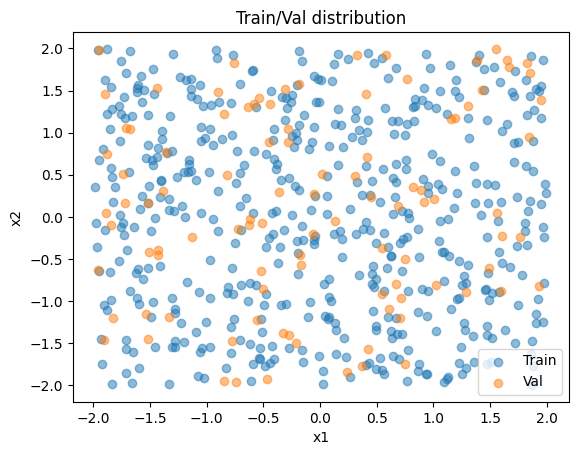

In [ ]:
def true_function(x1, x2):
    return np.sin(x1) + np.cos(x2)

def mse_loss(y_hat, y):
    """
    0.5 * mean((y_hat - y)^2)
    """
    return 0.5 * np.mean((y_hat - y)**2)

def generate_dataset(N_train=500, N_val=100):
    # Train
    x1_train = np.random.uniform(-2, 2, size=N_train)
    x2_train = np.random.uniform(-2, 2, size=N_train)
    y_train  = true_function(x1_train, x2_train)

    # Val
    x1_val = np.random.uniform(-2, 2, size=N_val)
    x2_val = np.random.uniform(-2, 2, size=N_val)
    y_val  = true_function(x1_val, x2_val)

    return (x1_train, x2_train, y_train), (x1_val, x2_val, y_val)

# Dataset generation from function
(x1_train, x2_train, y_train), (x1_val, x2_val, y_val) = generate_dataset()

# Lets check distribution on train/val
plt.scatter(x1_train, x2_train, alpha=0.5, label='Train')
plt.scatter(x1_val, x2_val, alpha=0.5, label='Val')
plt.title("Train/Val distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


In [ ]:
import numpy as np

class TinyTanhMLP:
    """
    A small 2 -> 8 -> 1 MLP using tanh activations, trained with manual backprop.
    """
    def __init__(self):
        # Model parameters: w1,b1 for hidden layer; w2,b2 for output
        # w1: shape (2,8), b1: shape (8,)
        # w2: shape (8,),  b2: scalar
        self.params = {
            "w1": np.random.randn(2, 8),
            "b1": np.random.randn(8),
            "w2": np.random.randn(8),
            "b2": np.random.randn()
        }

    def activation(self, z):
        """
        Tanh activation.
        """
        return np.tanh(z)

    def activation_deriv(self, z):
        """
        Derivative of tanh(z) = ???
        """
        return <YOUR CODE HERE>

    def forward(self, x1, x2):
        """
        Forward pass: x1, x2 of shape (N,).
        Returns a dict with intermediate values for backprop.
        """
        X = np.column_stack([x1, x2])  # (N,2)

        # Hidden layer: z1 -> h1
        z1 = <YOUR CODE HERE>  # (N,8)
        h1 = <YOUR CODE HERE>  # (N,8)

        # Output layer: z2 -> y_hat
        z2 = <YOUR CODE HERE>    # (N,)
        y_hat = <YOUR CODE HERE> # shape (N,)

        return {
            "X": X,
            "z1": z1,
            "h1": h1,
            "z2": z2,
            "y_hat": y_hat
        }

    def backward(self, x1, x2, y, forward_cache):
        """
        Computes gradients of all parameters w.r.t. MSE loss.
        Returns a dict 'grads' with same keys as self.params.
        """
        X    = forward_cache["X"]   # (N,2)
        z1   = forward_cache["z1"]  # (N,8)
        h1   = forward_cache["h1"]  # (N,8)
        z2   = forward_cache["z2"]  # (N,)
        y_hat= forward_cache["y_hat"] # (N,)

        N = len(y)

        dLoss_dy = <YOUR CODE HERE>  # (N,)

        # Expand dims for broadcasting in next step
        dLoss_dz2 = dLoss_dy.reshape(-1,1)  # (N,1)

        grads = {}

        grads["w2"] = <YOUR CODE HERE> # Dont forget to .reshape(8,)
        grads["b2"] = <YOUR CODE HERE> # shape (1,) => scalar

        dLoss_dh1 = <YOUR CODE HERE> # Dont forget to .reshape(1,8) for w2
        dLoss_dz1 = <YOUR CODE HERE>  # (N,8)

        grads["w1"] = <YOUR CODE HERE>  # (2,8)
        grads["b1"] = <YOUR CODE HERE>  # (8,)

        return grads

    def predict(self, x1, x2):
        """
        Simple predict function: forward pass and return y_hat
        """
        cache = self.forward(x1, x2)
        return cache["y_hat"]

In [ ]:
learning_rate = 0.001
num_epochs = 15_000

model = TinyTanhMLP()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train forward
    cache_train = model.forward(x1_train, x2_train)
    loss_train = mse_loss(cache_train["y_hat"], y_train)

    # Backward + Param update
    grads = model.backward(x1_train, x2_train, y_train, cache_train)
    for k in model.params.keys():
      model.params[k] -= learning_rate * grads[k]

    # Val forward
    cache_val = model.forward(x1_val, x2_val)
    loss_val = mse_loss(cache_val["y_hat"], y_val)

    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # Info output
    if (epoch+1) % 1_000 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss={loss_train:.5f}, Val Loss={loss_val:.5f}")


In [ ]:
loss_plt(train_losses, val_losses)

In [ ]:
plot_res(model)